In [1]:
cd ../..

C:\Users\user\Documents\dton-wildfires-cleaner


In [2]:
from pprint import pprint

from sentinelhub import SHConfig

from floods_processing import process_flood_event
from settings import floods_settings, visualization_settings_floods
from queries import floods_query

from utils import get_env_var
from event_registry_utils import EventRegistry

In [3]:
################################ SETUP ################################
def print_titles(events):
    for event in events:
        print(event['id'] + ":",event['title'])

INSTANCE_ID_FLOODS = get_env_var("INSTANCE_ID_FLOODS")
EVENT_REGISTRY_API_KEY = get_env_var("EVENT_REGISTRY_API_KEY")
CLIENT_ID = get_env_var("CLIENT_ID")
CLIENT_SECRET = get_env_var("CLIENT_SECRET")

config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET
config.instance_id = INSTANCE_ID_FLOODS

date_start = "2020-01-01"
date_end = "2021-01-01"

event_registry = EventRegistry(EVENT_REGISTRY_API_KEY)
events = event_registry.get_events_from_media_intelligence(floods_query(date_start, date_end))

print_titles(events)

eng-6407288: 'Super storm' Cyclone Yasa hits Fiji, Government declares state of disaster
eng-6358658: Cyclone Burevi slams into eastern Sri Lanka
eng-6357444: Floods kill 5 in central, central highlands Vietnam
eng-6325540: Weathering storms together
eng-6304456: Philippines Typhoon Vamco leaves 53 dead
eng-6294917: Typhoon Vamco hammers main Philippine island of Luzon, paralyses
eng-6299327: 'Flood repair work hit due to delay in getting central funds' | Guwahati News - Times of India
eng-6258949: Philippines orders evacuations as world's strongest storm of 2020 approaches
eng-6249987: The European Union provides €1.3 million to assist floods victims in Vietnam 
eng-6248328: Emergency seeds set for farmers in flood zones
eng-6236976: Vietnam's economy to grow by 3% in 2020; storm situation worsens
eng-6231366: Bad weather forces CM Yediyurappa to cut short aerial survey of flood-hit Karnataka
eng-6223133: Hyderabad floods: Tamil Nadu contributes Rs 10 cr as a token of support to Telan

In [4]:
pprint(floods_settings)

{'EVENT_DURATION': 15,
 'LIMIT_INCLUDED': 0.8,
 'LIMIT_SCORE': 0.7,
 'MAX_S3_CC': 0.1,
 'S3_EVENT_DURATION': 15,
 'S3_WATER_MASK_TIMERANGE_LENGTH': 30,
 'WATER_MASK_DIFFERENCE_LIMIT': 0.1,
 'WATER_MASK_TIMERANGE_LENGTH': 30,
 'bbox_dimension': 150000,
 'data_collection': <DataCollection.SENTINEL1_IW: DataCollectionDefinition(
  api_id: S1GRD
  wfs_id: DSS3
  collection_type: Sentinel-1
  sensor_type: C-SAR
  processing_level: GRD
  swath_mode: IW
  polarization: DV
  resolution: HIGH
  orbit_direction: BOTH
  bands: ('VV', 'VH')
  is_timeless: False
)>,
 'data_collection_url': 'https://services.sentinel-hub.com/api/v1/process',
 'evalscript': '\n'
               '//VERSION=3\n'
               'function setup() {\n'
               '  return {\n'
               '    input: [{\n'
               '      bands: [\n'
               '        "VH", "dataMask"\n'
               '      ]\n'
               '    }],\n'
               '    mosaicking: Mosaicking.ORBIT,\n'
               '    output:

Settings are somewhat different compared to settings for wildfires and volcanoes.

* `EVENT_DURATION`: This is the "default" event duration length. We assume the flooding took place in `EVENT_DURATION` days until event date.

* `WATER_MASK_TIMERANGE_LENGTH`: Water mask is generated from the period of `WATER_MASK_TIMERANGE_LENGTH` days up until `EVENT_DURATION` before the event date.

* `minimum_flooded_area`: The nature of the evalscript is such, that there are many (small features), so we set a cutoff for the minimum flooded area we consider. Without that, pipeline would nearly always produce a result, as there are always some "flooded" pixels. In square meters. 

* `WATER_MASK_DIFFERENCE_LIMIT`: If the difference between the water masks is greater than this value, sentinel-3 OLCI is used. The difference is defined as number of differing pixels / number of pixels classified as water by sentinel-3 OLCI.

* `MAX_S3_CC`: Maximum cloud coverage in the sentinel-3 OLCI water mask to even consider using it.

* `S3_EVENT_DURATION`: Due to peculiarities of creodias (timeouts and crashing), s3 multitemporal requests need to use a shorter timespan.

* `S3_WATER_MASK_TIMERANGE_LENGTH`: Similar as `S3_EVENT_DURATION`.

In [5]:
pprint(visualization_settings_floods)

{'MAX_CLOUD_COVERAGE_SEARCH': 0.8,
 'MAX_CLOUD_COVERAGE_VISUALIZATION': 0.7,
 'MIN_COVERAGE': 0.7,
 'TIMERANGE_AFTER': 20,
 'TIMERANGE_AFTER_S1': 40,
 'TIMERANGE_BEFORE': 50,
 'VISUALIZATION_EVENT_DATE_OFFSET': 7,
 'cloud_coverage_evalscript': '\n'
                              'function evaluatePixel(sample) {\n'
                              '  if(sample.CLM === 1) {\n'
                              '    return [1]\n'
                              '  }\n'
                              '  return [0];\n'
                              '}\n'
                              '\n'
                              'function setup() {\n'
                              '  return {\n'
                              '    input: [{\n'
                              '      bands: [\n'
                              '        "CLM"\n'
                              '      ]\n'
                              '    }],\n'
                              '    output: {\n'
                              '      bands: 

Visualization settings only differ by having `VISUALIZATION_EVENT_DATE_OFFSET`. "Before" images will be chosen in the period from up to event date - `VISUALIZATION_EVENT_DATE_OFFSET` and vice versa for "after" images. This is because we don't have an "exact" date and we want to potentially include a "during" period.

In [6]:
# Select an event id to run
event_id = "eng-6407288"

event = next((e for e in events if e["id"] == event_id), None)

The images below show the steps in the pipeline.

#### Fetching data
1. Sentinel-1 water mask. Dark areas were classified as water.
2. Sentinel-3 OLCI water mask. Dark areas were classified as water.
3. Water detection during event period. Light areas were classified as water
4. Difference between the water mask and water detection during the event period. Light pixels denote "flooded" areas, i.e. areas which were not classified as water in water mask, but were classified as such "during" the event. Notice there is a lot of noise. This is the input to pinpointing process.
5. Difference between Sentinel-1 and Sentinel-3 water masks. Lighter areas denoted pixels, which were classified as water in either, but not both.

#### Pinpointing process
1. Initially cleared image, where a portion of small features (usually 1 pixel big) were removed. It keeps `LIMIT_INCLUDED` of the largest features, or at most 500 largest features.

2. Join features which are close into clusters (bigger features).

3. Remove all clusters which are below the `minimum_flooded_area` size

4. Assign scores to clusters and take `LIMIT_SCORE` of the clusters with highest scores. This number is very high, we take most of the features which were left, as we mostly filtered sufficiently by size.

5. Final bbox


Fetching water masks ...
Fetched sentinel-1 water mask
Fetched sentinel-3 water mask
Difference 0.011206749642341004
Found 2930 features.


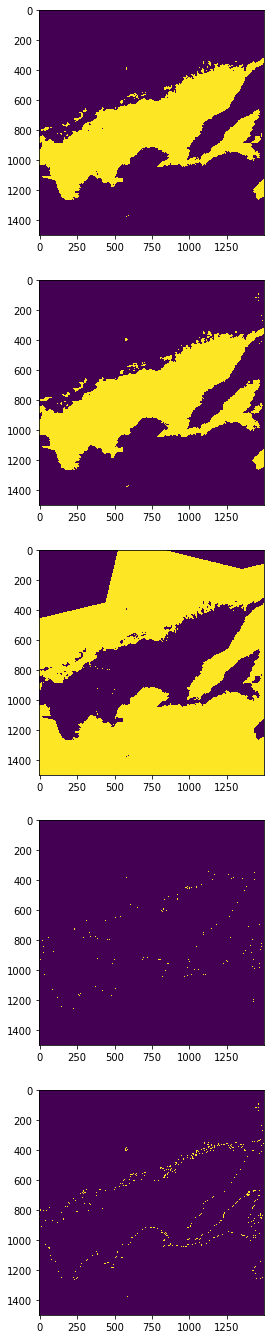

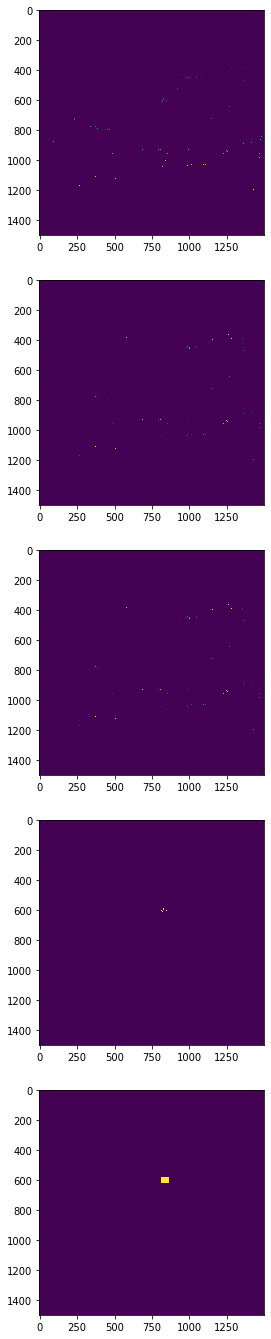

In [7]:
lat, lng, zoom, date, visualization_dates = process_flood_event(event, floods_settings, visualization_settings_floods, config, verbose=True)

In [8]:
print(lat, lng, zoom, date)
pprint(visualization_dates)

-16.4143177635614 179.33295924584837 12 2020-12-17
{'AWSEU_S1GRD': {'after': '2020-12-13', 'before': '2020-12-06'},
 'AWS_S2L1C': {'after': '2020-12-19', 'before': '2020-12-09'},
 'AWS_S2L2A': {'after': '2020-12-19', 'before': '2020-12-09'}}
